In [1]:
import fsspec
import cf_xarray
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='s3://nextgen-dmac-cloud-ingest/nos/cbofs/nos.cbofs.fields.best.nc.zarr', remote_protocol='s3', remote_options={'anon':True}, target_protocol='s3', target_options={'anon':True})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={})
ds

<xarray.Dataset>
Dimensions:         (ocean_time: 762, tracer: 3, s_rho: 20, s_w: 21,
                     boundary: 4, eta_rho: 291, xi_rho: 332, eta_psi: 290,
                     xi_psi: 331, eta_u: 291, xi_u: 331, eta_v: 290, xi_v: 332)
Coordinates:
    lat_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lat_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lon_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2023-09-17T01:00:00 ... 2023-...
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/97)
    Akk_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak         (ocean_time, tracer) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
    Akv_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    BioIter         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Charnok_alpha   (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...              ...
    theta_s         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u               (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 146, 166), meta=np.ndarray>
    v               (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 145, 166), meta=np.ndarray>
    w               (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 146, 166), meta=np.ndarray>
    xl              (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
Attributes: (12/36)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:    WEST   SOUTH  EAST   NORTH  \nzeta:    Clo ...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bio_file:          ROMS/Nonlinear/Biology/hypoxia_srm.h
    ...                ...
    svn_url:           
    tide_file:         nos.cbofs.roms.tides.nc
    tiling:            008x016
    title:             cbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

In [3]:
mask = ds[f'mask_{ds.salt.cf["latitude"].name.split("_")[1]}'].cf.isel(time=0)
mask[:-1,:] = mask[:-1,:].where(mask[1:,:] == 1, 0)
mask[:,:-1] = mask[:,:-1].where(mask[:,1:] == 1, 0)
mask[1:,:] = mask[1:,:].where(mask[:-1,:] == 1, 0)
mask[:,1:] = mask[:,1:].where(mask[:,:-1] == 1, 0)

da = ds.salt.cf.isel(time=0).cf.sel(vertical=0, method='nearest').where(mask == 1)
da

<xarray.DataArray 'salt' (eta_rho: 291, xi_rho: 332)>
dask.array<where, shape=(291, 332), dtype=float32, chunksize=(146, 166), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    ocean_time  datetime64[ns] 2023-09-17T01:00:00
    s_rho       float64 -0.025
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    cell_methods:   ocean_time: point
    field:          salinity
    grid:           grid
    location:       face
    long_name:      salinity
    standard_name:  sea_water_practical_salinity
    time:           ocean_time

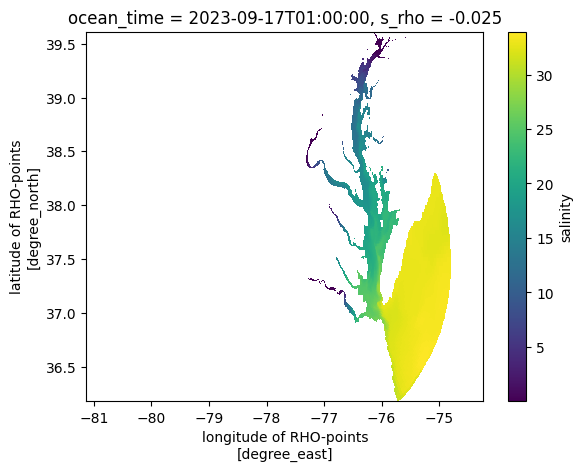

In [4]:
da.cf.plot(x='longitude', y='latitude')